In [ ]:
"import required libraries"
#data analysis
import pandas as pd
#visualization library
import matplotlib.pyplot as plt
import seaborn as sns
#surprise reader
from surprise import Dataset, Reader
#recomendation algorithms
from surprise import SVD
from surprise import SlopeOne
from surprise import NMF
from surprise import NormalPredictor
from surprise import KNNBasic
from surprise import KNNBaseline
from surprise import KNNWithMeans
from surprise import KNNWithZScore
from surprise import BaselineOnly
from surprise import CoClustering
#model selection
from surprise.model_selection import cross_validate
from surprise.model_selection import GridSearchCV
#saving the model
import pickle

#set graphic properties
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set_style("whitegrid")

In [ ]:
#read the movies and ratings file
ratings = pd.read_csv('data/ratings.csv')
movies = pd.read_csv('data/movies.csv')

# 1. Analysis

In [3]:
movies.head(3)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [4]:
ratings.head(3)

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224


In [5]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


There are no null values. And the shape of the ratings data is 100836 rows & 4 columns. Eliminate any movies that were rated by small percentage of user, similaly, eliminate any such users who have not rated enough movies. 
1. To qualify a movie, a minimum of 5 users should have voted a movie.
2. To qualify a user, a minimum of 20 movies should have voted by the user.

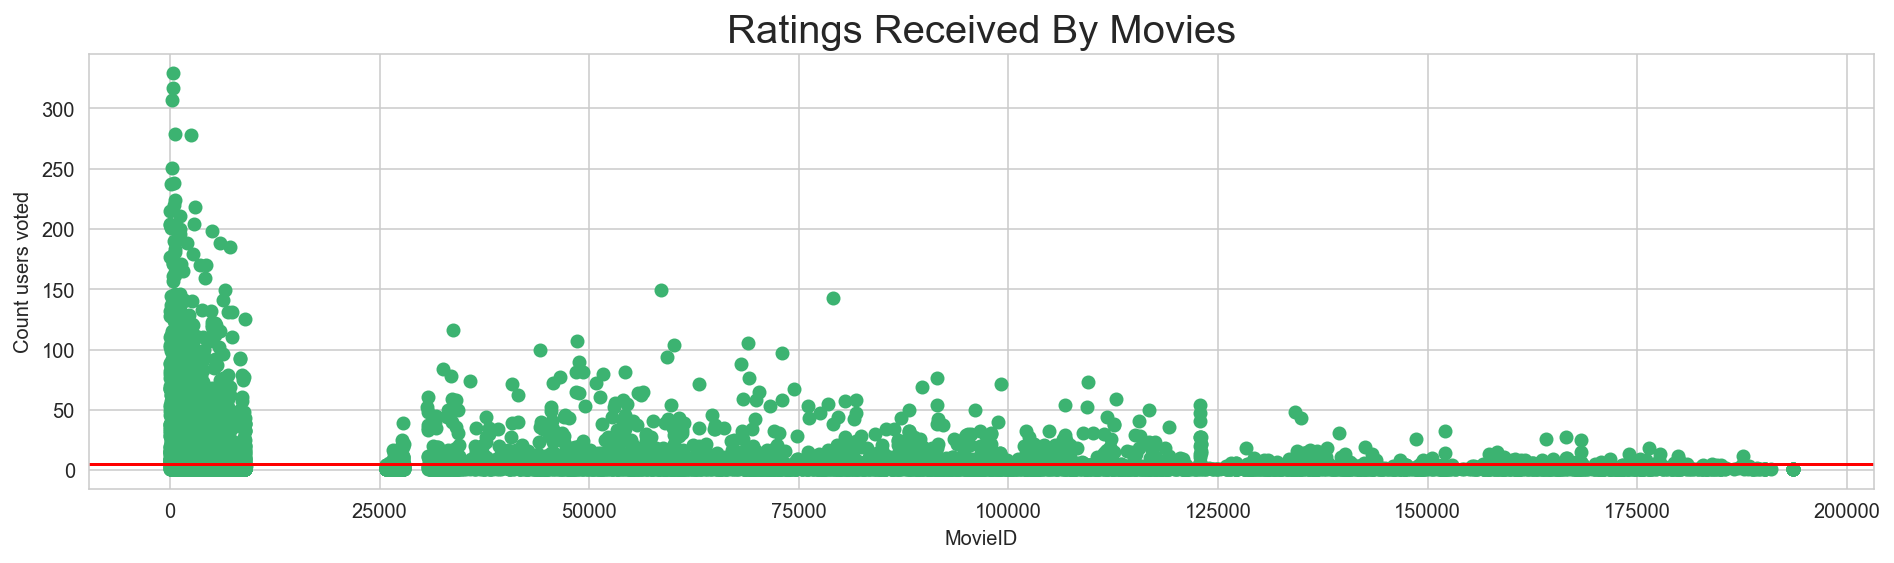

In [6]:
#visualize review counts for movies & above criteria
votes_received = ratings.groupby('movieId')['rating'].agg('count')

f,ax = plt.subplots(1,1,figsize=(16,4))
# ratings['rating'].plot(kind='hist')
plt.scatter(votes_received.index,votes_received,color='mediumseagreen')
plt.axhline(y=5,color='r')
plt.xlabel('MovieID')
plt.ylabel('Count users voted')
plt.title("Ratings Received By Movies", fontsize = 20)
plt.show()

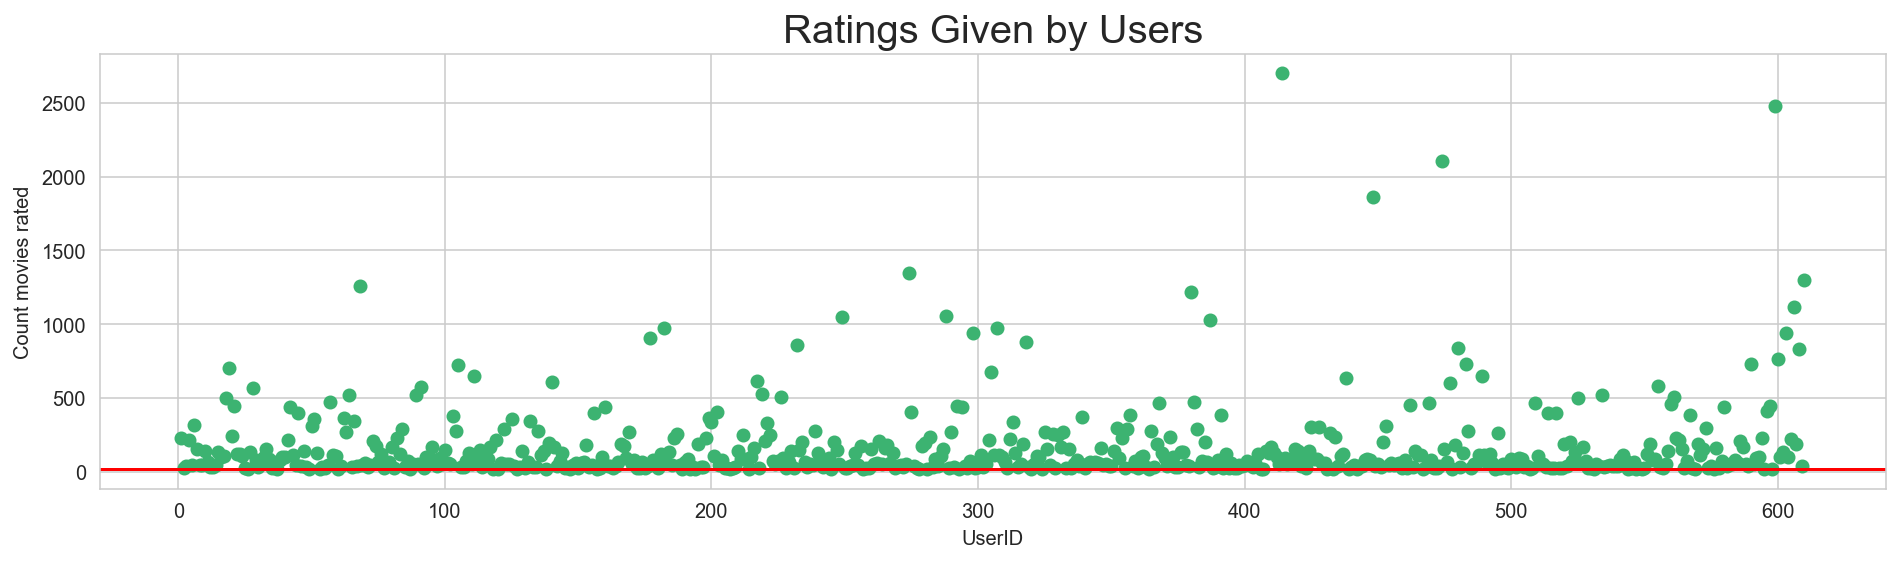

In [7]:
#visualize ratings given by users for movies & above criteria
votes_given = ratings.groupby('userId')['rating'].agg('count')

f,ax = plt.subplots(1,1,figsize=(16,4))
# ratings['rating'].plot(kind='hist')
plt.scatter(votes_given.index,votes_given,color='mediumseagreen')
plt.axhline(y=20,color='r')
plt.xlabel('UserID')
plt.ylabel('Count movies rated')
plt.title("Ratings Given by Users", fontsize = 20)
plt.show()

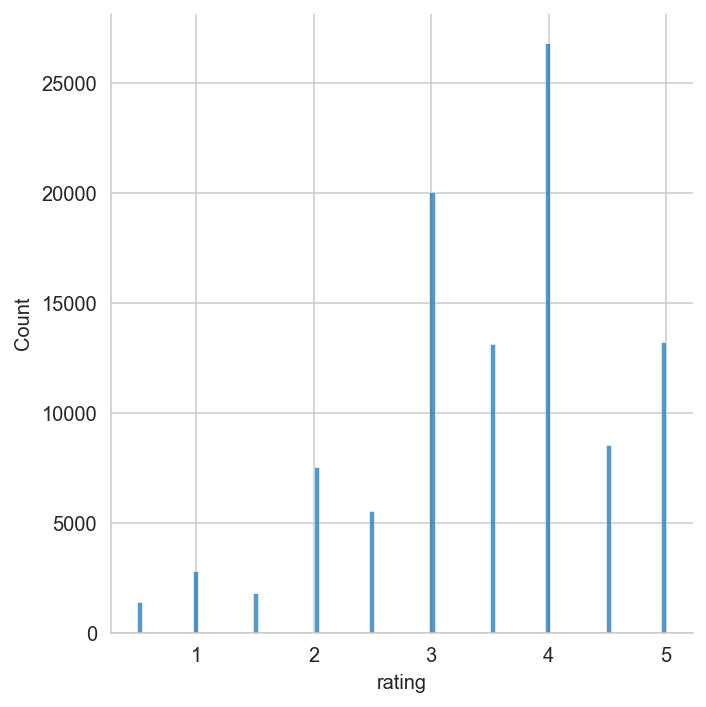

In [8]:
#rating distribution
sns.displot(ratings, x ="rating");

In [9]:
#unique users and movies
print("Total unique users in the ratings data: {}".format(len(ratings.userId.unique())))
print("Total unique movies in the ratings data: {}".format(len(ratings.movieId.unique())))

Total unique users in the ratings data: 610
Total unique movies in the ratings data: 9724


# 2. Transformation

In [96]:
def filter_ratings(df):
    '''
    Function filters the dataframe based on the following criteria
    1. movie should be rated by atleast 20 users
    2. user should have voted atleast 50 movies
    
    INPUT:
        1. df(pandas dataframe): the original ratings dataframe with all values
        
    OUTPUT:
        1. filtered_ratings(pandas dataframe): filtered dataframe accoridng to the defined criteria
    '''
    #filter movies
    filter_movies = ratings.groupby('movieId')['rating'].size() 
    filter_movies = filter_movies[filter_movies > 80] \
                        .index.tolist()
    #filter users
    filter_users = ratings.groupby('userId')['rating'].size()
    filter_users = filter_users[filter_users > 30] \
                    .index.tolist()
    
    #filter ratings dataframe
    filtered_ratings = df[(df['movieId'].isin(filter_movies)) & (df['userId'].isin(filter_users))]
    
    #print shape
    print("Shape of ratings data before filtering: {}" .format(df.shape))
    print("Shape of ratings data before after: {}" .format(filtered_ratings.shape))
    
    return filtered_ratings


In [97]:
ratings_df = filter_ratings(ratings)

Shape of ratings data before filtering: (100836, 4)
Shape of ratings data before after: (25065, 4)


In [98]:
def filter_movies(movies, ratings):
    '''
    Function filters the movies data based movie ids in ratings data
    
    INPUT:
        1. movies(pandas dataframe): original movies data with all the movies
        2. ratings(pandas dataframe): filtered ratings data
        
    OUTPUT: 
        1. filtered_movies(pandas dataframe): filtered movies dataframe
    '''
    #get the movie ids from ratings
    movie_id_list = ratings.movieId.tolist()
    #filter the movies
    filtered_movies = movies[movies['movieId'].isin(movie_id_list)]
    
    #print shape
    print("Shape of movie data before filtering: {}" .format(movies.shape))
    print("Shape of movie data before after: {}" .format(filtered_movies.shape))
    
    return filtered_movies

In [99]:
movies_df = filter_movies(movies, ratings_df)

Shape of movie data before filtering: (9742, 3)
Shape of movie data before after: (206, 3)


In [100]:
def save_csv(movies, ratings):
    '''
    Function saves the given dataframes as .csv files in the data folder
    
    INPUT: 
        1. movies(pandas dataframe): dataframe to save as movies.csv
        2. ratings(pandas dataframe): dataframe to save as ratings.csv
        
    OUTPUT:
        None
    '''
    #save the movies dataframe 
    movies.to_csv('data/m_movies.csv', index=False)
    #save the ratings dataframe
    ratings.to_csv('data/m_ratings.csv', index=False)
    print('Successfully saved movies.csv & ratings.csv')

In [101]:
save_csv(movies_df, ratings_df)

Successfully saved movies.csv & ratings.csv


# 3. Modeling

In [102]:
#define a reader
reader = Reader(rating_scale=(0.5, 5))
#convert ratings to suprise dataframe form
data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)

In [103]:
def get_benchmarks(data):
    '''
    Function to cross-validate all the algorithms to find their rmse
    
    INPUT: 
        1.data(suprise-dataframe): dataframe with userID, movieID & ratings columns
        
    OUTPUT:
        2. df(pandas dataframe): dataframe with algo name, rmse & time for fit
    
    '''
    benchmark = []
    # Iterate over all algorithms
    for algorithm in [SVD(), SlopeOne(), NMF(), NormalPredictor(), KNNBaseline(), KNNBasic(), KNNWithMeans(), KNNWithZScore(), BaselineOnly(), CoClustering()]:
        # Perform cross validation
        results = cross_validate(algorithm, data, measures=['RMSE'], cv=3, verbose=False)

        # Get results & append algorithm name
        tmp = pd.DataFrame.from_dict(results).mean(axis=0)
        tmp = tmp.append(pd.Series([str(algorithm).split(' ')[0].split('.')[-1]], index=['Algorithm']))
        benchmark.append(tmp)

    df = pd.DataFrame(benchmark).set_index('Algorithm').sort_values('test_rmse')   

    return df
        

In [104]:
#call the function to get the best model
df = get_benchmarks(data)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Estimating biases using als...


In [105]:
df

,test_rmse,fit_time,test_time
Algorithm,,,
KNNBaseline,0.813876,0.048028,1.172242
SlopeOne,0.823353,0.029174,0.331930
SVD,0.823951,0.902902,0.066492
KNNWithMeans,0.824188,0.048335,0.992801
BaselineOnly,0.824991,0.015000,0.032883
KNNWithZScore,0.826356,0.058733,1.066308
NMF,0.848280,0.825686,0.053807
KNNBasic,0.857809,0.033045,0.909658
CoClustering,0.858563,0.216402,0.057136


In [107]:
#make a trainset
trainset = data.build_full_trainset()

In [108]:
#fit the data to svd
kknB = KNNBaseline()
#generate the model
model = kknB.fit(trainset)

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.


In [110]:
#export the model as pickle
filename = "model/rec_model.pkl"
with open(filename, 'wb') as file:
    pickle.dump(model, file)

In [112]:
file = 'model/rec_model.pkl'
with open(file, 'rb') as file:
    model = pickle.load(file)

In [114]:
movies_df

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
5,6,Heat (1995),Action|Crime|Thriller
9,10,GoldenEye (1995),Action|Adventure|Thriller
15,16,Casino (1995),Crime|Drama
...,...,...,...
6772,60069,WALL·E (2008),Adventure|Animation|Children|Romance|Sci-Fi
7010,68157,Inglourious Basterds (2009),Action|Drama|War
7039,68954,Up (2009),Adventure|Animation|Children|Drama
7212,72998,Avatar (2009),Action|Adventure|Sci-Fi|IMAX
